In [1]:
!pip install pandas numpy scikit-learn seaborn matplotlib

In [1]:
import pandas as pd
import numpy as np

# --- Generate Synthetic Data for 1000 Remote Workers ---
num_employees = 1000
np.random.seed(42) # for reproducibility

# Features
work_hours = np.random.normal(8, 2, num_employees).clip(4, 16)
break_time = np.random.normal(45, 20, num_employees).clip(10, 90)
meeting_hours = np.random.normal(10, 5, num_employees).clip(0, 40)
sentiment_scores = np.random.normal(0, 0.5, num_employees).clip(-1, 1)
completion_rate = np.random.normal(0.85, 0.15, num_employees).clip(0.5, 1.0)

# --- Create a Burnout Score based on weighted factors (Objective 3) ---
# High work hours, high meetings, and low sentiment/breaks/completion contribute to burnout
burnout_score = (
    (work_hours / 4) +                 # Weight work hours heavily
    (meeting_hours / 10) -             # Meetings contribute
    (break_time / 45) -                # Low break time increases score
    (sentiment_scores * 2) -           # Negative sentiment increases score
    (completion_rate)                  # Low completion rate increases score
)

# Normalize the score to be between 0 and 1
burnout_score = (burnout_score - np.min(burnout_score)) / (np.max(burnout_score) - np.min(burnout_score))

# Add some random noise to make it less deterministic
burnout_score += np.random.normal(0, 0.1, num_employees)
burnout_score = burnout_score.clip(0, 1)


# Create a binary label: 1 if at risk, 0 if not
# We set the threshold at 0.6, meaning the top ~40% are at risk
burnout_label = (burnout_score > 0.6).astype(int)

# --- Assemble the DataFrame ---
df = pd.DataFrame({
    'employee_id': range(1, num_employees + 1),
    'avg_work_hours_per_day': work_hours,
    'avg_break_time_minutes': break_time,
    'meeting_hours_per_week': meeting_hours,
    'sentiment_score': sentiment_scores,
    'task_completion_rate': completion_rate,
    'burnout_risk_score': burnout_score, # The continuous risk rating
    'burnout_label': burnout_label # The binary target for classification
})


# Save the dataset to a CSV file
df.to_csv('digital_burnout_dataset.csv', index=False)

print("Dataset created and saved as digital_burnout_dataset.csv")
print(df.head())
print(f"\nNumber of employees at risk (burnout_label=1): {df['burnout_label'].sum()}")

Dataset created and saved as digital_burnout_dataset.csv
   employee_id  avg_work_hours_per_day  avg_break_time_minutes  \
0            1                8.993428               72.987109   
1            2                7.723471               63.492674   
2            3                9.295377               46.192607   
3            4               11.046060               32.061264   
4            5                7.531693               58.964466   

   meeting_hours_per_week  sentiment_score  task_completion_rate  \
0                6.624109        -0.953904              0.720476   
1                9.277407        -0.430193              0.845319   
2                6.037900        -0.206803              0.852703   
3                8.460192         0.943844              0.920895   
4                0.531927         0.278277              0.644971   

   burnout_risk_score  burnout_label  
0            0.665448              1  
1            0.516579              0  
2            0.38225

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import joblib

# Load the dataset
df = pd.read_csv('digital_burnout_dataset.csv')

# Prepare the data
# X includes the features for prediction, y is the target label
X = df.drop(['employee_id', 'burnout_risk_score', 'burnout_label'], axis=1)
y = df['burnout_label']

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features to have zero mean and unit variance for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Initialize and train the Ensemble Model (Objective 3) ---
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

print("Model training complete.")

# --- Save the model and scaler for later use in the application ---
joblib.dump(model, 'burnout_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("Model and scaler saved as 'burnout_model.pkl' and 'scaler.pkl'.")

Model training complete.
Model and scaler saved as 'burnout_model.pkl' and 'scaler.pkl'.


--- Model Performance Evaluation ---
Accuracy: 0.7950

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       129
           1       0.76      0.62      0.68        71

    accuracy                           0.80       200
   macro avg       0.78      0.76      0.77       200
weighted avg       0.79      0.80      0.79       200



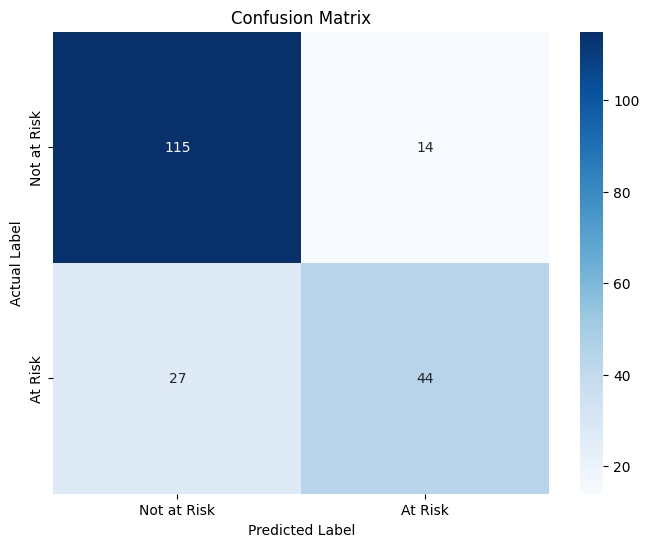

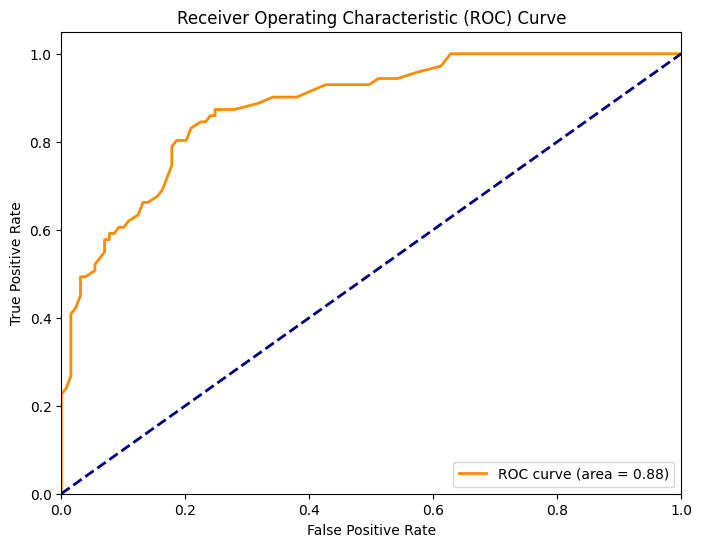

AUC Score: 0.8802


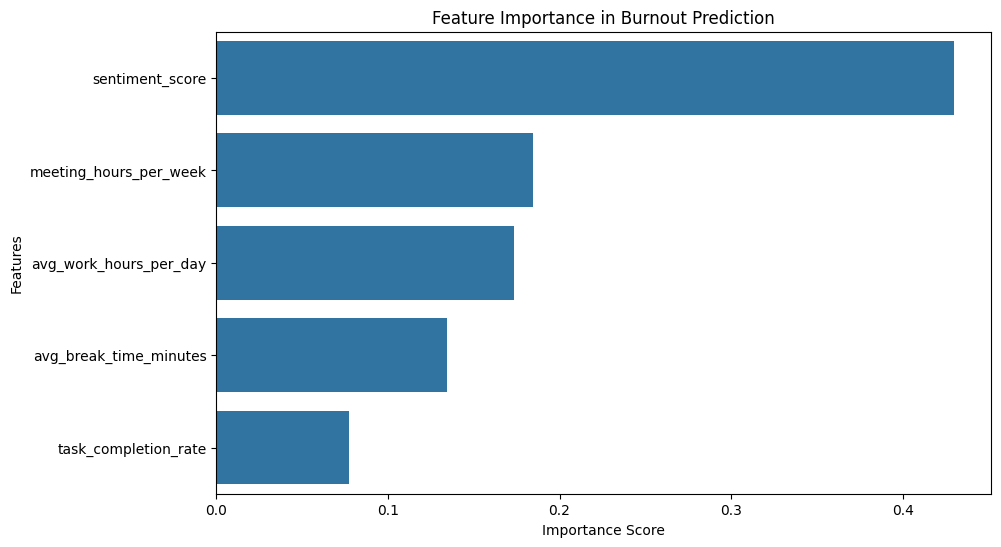

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score

# --- Make predictions on the test set ---
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] # Probabilities for the '1' class

# --- 1. Basic Metrics ---
print("--- Model Performance Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# --- 2. Confusion Matrix Visualization ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not at Risk', 'At Risk'],
            yticklabels=['Not at Risk', 'At Risk'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# --- 3. ROC Curve and AUC Score Visualization ---
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
print(f"AUC Score: {auc_score:.4f}")

# --- 4. Feature Importance Visualization ---
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.importance, y=feature_importances.index)
plt.title('Feature Importance in Burnout Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()